## Analyze the models from analysis_004 (five subjects) for paramters, performance, entropy, distortion

#### General notes:

- A few of the results are not consistent with results in analysis_003. This suggests that viral gets stuck in local minima that can change interpretation
- Suggests need for better way to determine K (number of objects). (Max response +-1 ?)
- Suggests need for multiple runs of model for each subject/target/state. Fine.
- Need to implement location tuning.
- Will want to implement "tuning bandwidth" analyses
- Need to focus on candles vs. peaches. Plot everything as img/pcp ratios for candles vs. peaches.
- Need to compare prediction performance to better baseline--where you just sample the most likely number. Because that may be all that some of these models are doing.
- Need a "most probable object" analysis. From the looks of it, for most models this will be a single pixel, or a single object covering the whole image. 
- Need to perform some simpler analyses that just compare response patterns between imagery and vision. Are the distributions the same? Okay, are there regions of more/less congruence? This kind of "mvpa" analyses might be really helpful.
- Need to plot the likelihood function over range of different conditioned object counts for the noise parameters estimated by running viral.
- Did I ever look at pixelwise entropy maps? I should.
- If we overestimate number of objects (K) do we then overestimate the "forgetting" parameter?
- Question that has been bugging me: does likelihood assign 0 probability if response exceeds K? I think it does.
- CRP prior doesn't make sense because we get lots of explicit information about the number of objects directly from the data
- To analyze distortion could consider figure/ground differences. Could also estimate "most probable object", then fix that, then estimate "second most probable object", etc.


In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from PIL.Image import open as open_image
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import seaborn as sns

In [3]:
from imagery_psychophysics.src.variational import *
from imagery_psychophysics.utils.variational_utils import *

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_ThTjCr.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda: GeForce GTX TITAN X (0000:01:00.0)


In [4]:
from skimage.transform import resize
from os.path import join

## Retrieve data from training run in analysis_004

In [5]:
store = pd.io.pytables.HDFStore('/home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/analysis/five_subjects_(10x16).h5','r')

store.keys()

models = store['models']

store.close()

In [6]:
models

,subject,state,target,model
0,gsy,pcp,candle_01,<imagery_psychophysics.src.variational.VI obje...
1,gsy,pcp,peaches_05,<imagery_psychophysics.src.variational.VI obje...
2,gsy,img,candle_01,<imagery_psychophysics.src.variational.VI obje...
3,gsy,img,peaches_05,<imagery_psychophysics.src.variational.VI obje...
4,AS,pcp,candle_01,<imagery_psychophysics.src.variational.VI obje...
5,AS,pcp,peaches_05,<imagery_psychophysics.src.variational.VI obje...
6,AS,img,candle_01,<imagery_psychophysics.src.variational.VI obje...
7,AS,img,peaches_05,<imagery_psychophysics.src.variational.VI obje...
8,ltd,pcp,candle_01,<imagery_psychophysics.src.variational.VI obje...
9,ltd,pcp,peaches_05,<imagery_psychophysics.src.variational.VI obje...


In [7]:
metricsDf = make_new_df('subject+target', models['subject']+models['target'], models)

## Display and analyze model parameters

### Noise parameters

In [9]:
noiseParams = get_model_attribute('bestNoiseParam', models,shapeOfAttribute=(2,))
metricsDf = make_new_df('forgetting', 1-noiseParams[:,0], metricsDf)
metricsDf = make_new_df('halucinating', noiseParams[:,1], metricsDf)
metricsDf

,subject,state,target,subject+target,forgetting,halucinating
0,gsy,pcp,candle_01,gsycandle_01,0.001000,0.001000
1,gsy,pcp,peaches_05,gsypeaches_05,0.245408,0.001000
2,gsy,img,candle_01,gsycandle_01,0.041735,0.021346
3,gsy,img,peaches_05,gsypeaches_05,0.225041,0.021341
4,AS,pcp,candle_01,AScandle_01,0.021367,0.001000
5,AS,pcp,peaches_05,ASpeaches_05,0.143571,0.041687
6,AS,img,candle_01,AScandle_01,0.062102,0.041691
7,AS,img,peaches_05,ASpeaches_05,0.082469,0.021345
8,ltd,pcp,candle_01,ltdcandle_01,0.001000,0.021347
9,ltd,pcp,peaches_05,ltdpeaches_05,0.041735,0.021346


##### The memory plane
People forget

But note that some instabilities emerge here. Unlike last runs in analysis_003, KLcandle is weird, with super high forgetting rate for *vision* and much lower for imagery. So this suggests that high-forgetting rate configurations can be a local minimum.

(-0.043380065926069536, 0.55)

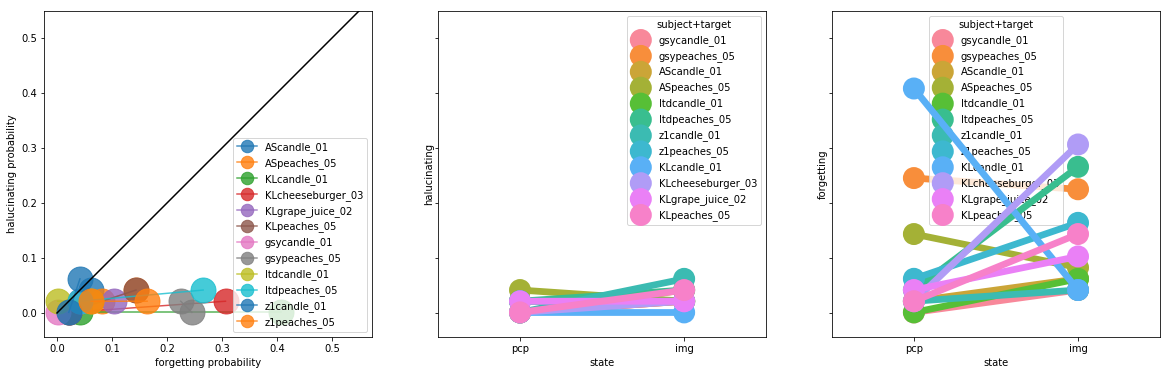

In [10]:
sharedYLim = 0.55
fig = plt.figure(figsize=(20,6))
ax = fig.subplots(nrows=1,ncols=3, sharey=True)
for name,grp in metricsDf.groupby('subject+target'):
    forget = grp.forgetting
    halluc = grp.halucinating
    ax[0].plot(forget,halluc, 'o-', label=name,markersize=25,alpha=0.8)

ax[0].plot(np.linspace(0.,sharedYLim),np.linspace(0.,sharedYLim),'k',)
ax[0].legend(markerscale=.5,loc = 'best',)
ax[0].set_aspect('equal')
ax[0].set_ylabel('halucinating probability')
ax[0].set_xlabel('forgetting probability')

sns.pointplot('state', 'halucinating', data=metricsDf,hue='subject+target',ax=ax[1],aspect=1,scale=2.5)
ax[1].set_ylim(None,sharedYLim)
sns.pointplot('state', 'forgetting', data=metricsDf,hue='subject+target',ax=ax[2],aspect=1,scale=2.5)
ax[2].set_ylim(None,sharedYLim)

### The variational posterior, q(Z)
For each (subject, target image) pair, display a 3 x K grid with:
<br>
the target image
<br>
q(Z=k) for vision
<br>
q(Z=k) for imagery

In [11]:
def load_target_image(target_image, shape=None):
    '''
    load_target_image(target_image, shape)
    opens mask image given name (e.g., 'candle_01')
    '''
    drive = '/home/tnaselar/FAST'
    ##base directory
    base = 'imagery_psychophysics/multi_poly_probes'
    mask_place = 'masks/processed'
    mask_image_file = target_image+'_mask.png'
    thisFile = join(drive, base, mask_place, mask_image_file)
    print 'opening %s' %(thisFile)
    targetObjectMap = np.array(open(thisFile,mode='r').convert('L'))
    if shape is None:
        return targetObjectMap
    else:
        return resize(targetObjectMap,shape,order=0,preserve_range=True)
    

In [12]:
def group_display_qZ(target_image, modelDf, image_shape, numCols):
    pixelvals = []
    obj = []
    states = []
    targetObjectMap = load_target_image(target_image, image_shape)
    numpixels = np.prod(image_shape)
    for k in range(numCols):
            obj += ['q(Z=%d)' %(k)]*numpixels
            states += [target_image]*numpixels
            pixelvals += targetObjectMap.flatten().tolist()
    
    for idx,dfRows in modelDf[modelDf['target']==target_image].iterrows():
        ##fill the pixel vals
        qZ = dfRows.model.bestQZ
        subj = dfRows.subject
        targ = dfRows.target
        state = dfRows.state
        K = qZ.shape[0]  ##this should always be the same, but easiest to just re-grab it here
        numpixels = qZ.shape[1] ##same as above
        assert K == numCols
        for k in range(K):
            obj += ['q(Z=%d)' %(k)]*numpixels
            states += [subj+'_'+'_'+state]*numpixels
            pixelvals += qZ[k].tolist()

    imgDf = pd.DataFrame({'val':pixelvals, 'obj':obj, 'state':states})
    fg = sns.FacetGrid(imgDf, row = 'state', col='obj',margin_titles=True)
    def myimshow(img,color=None):
        plt.imshow(img.values.reshape(image_shape))
    fg.map(myimshow, 'val')
    fg.set(yticks=[])
    fg.set(xticks=[])
    fg.fig.tight_layout()
    return imgDf, fg

##### The candle
Minus the flame

opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/candle_01_mask.png


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


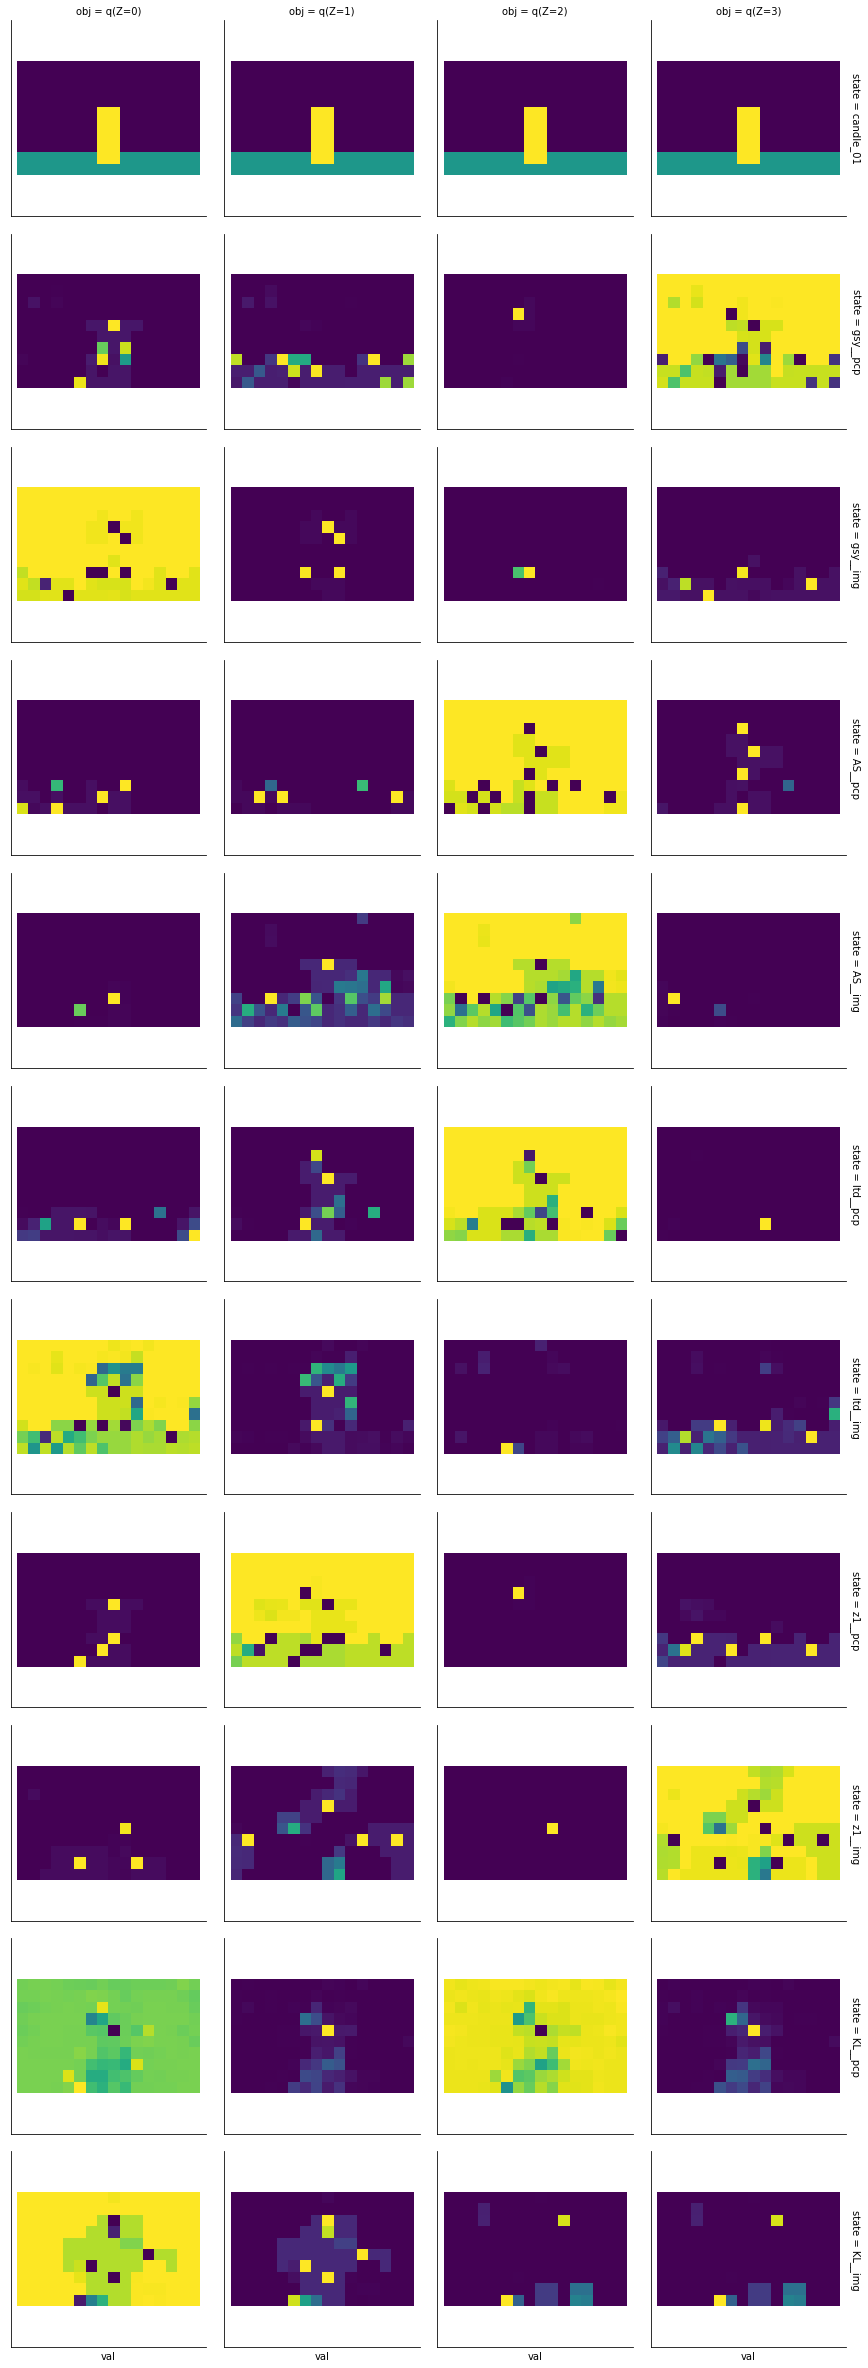

In [13]:
K = 4
candleDf,fg = group_display_qZ('candle_01', models, (10,16), K)

##### Grape juice and white bread

opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/grape_juice_02_mask.png


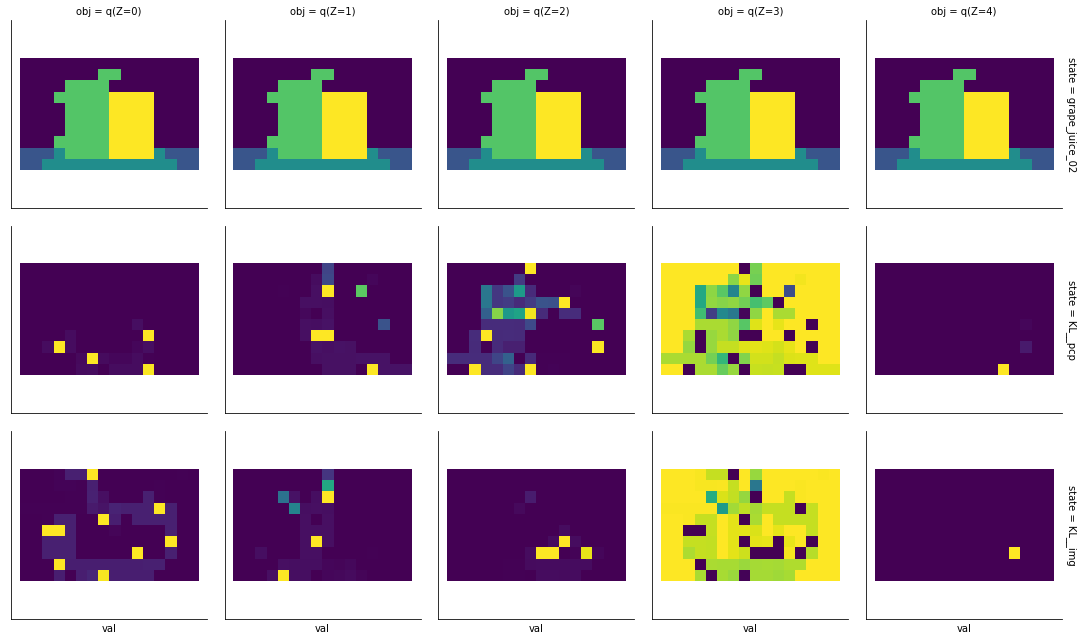

In [14]:
K = 5
grapeDf = group_display_qZ('grape_juice_02', models, (10,16), K)

##### Cheeseburger

opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/cheeseburger_03_mask.png


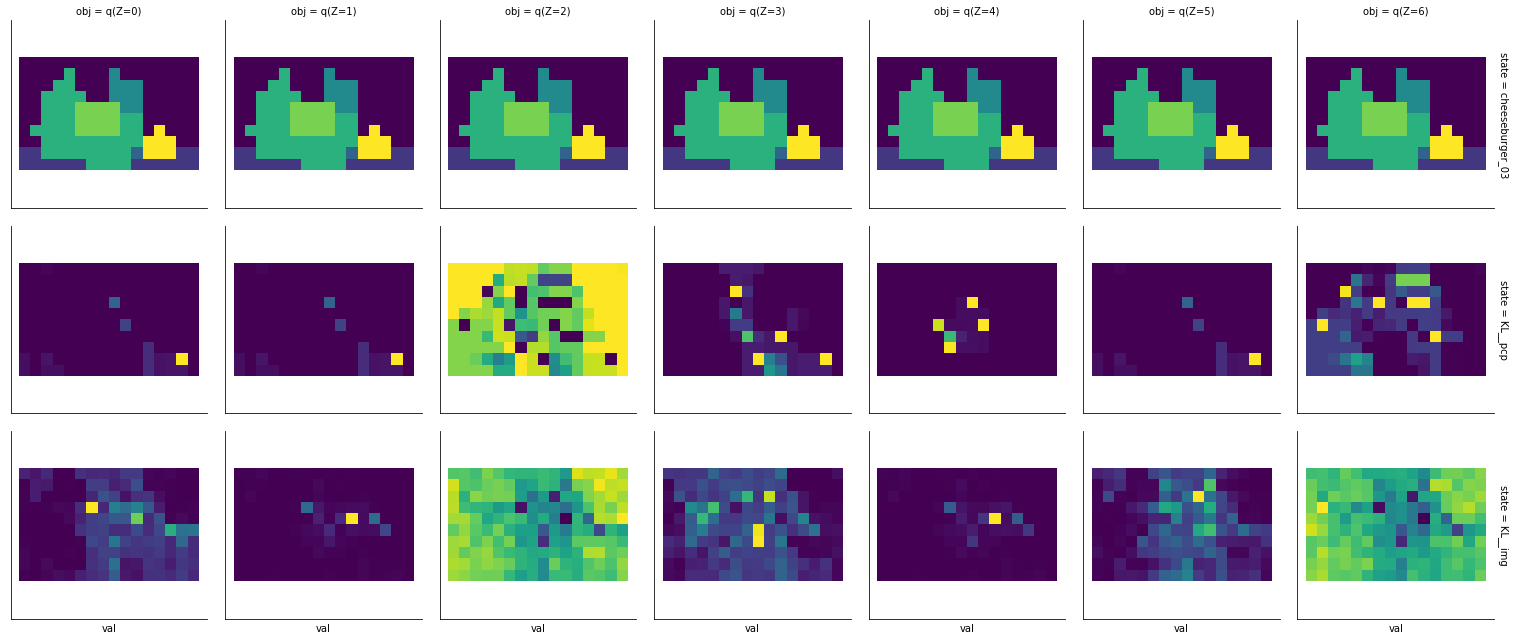

In [15]:
K = 7
grapeDf = group_display_qZ('cheeseburger_03', models, (10,16), K)

##### Peaches

opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/peaches_05_mask.png


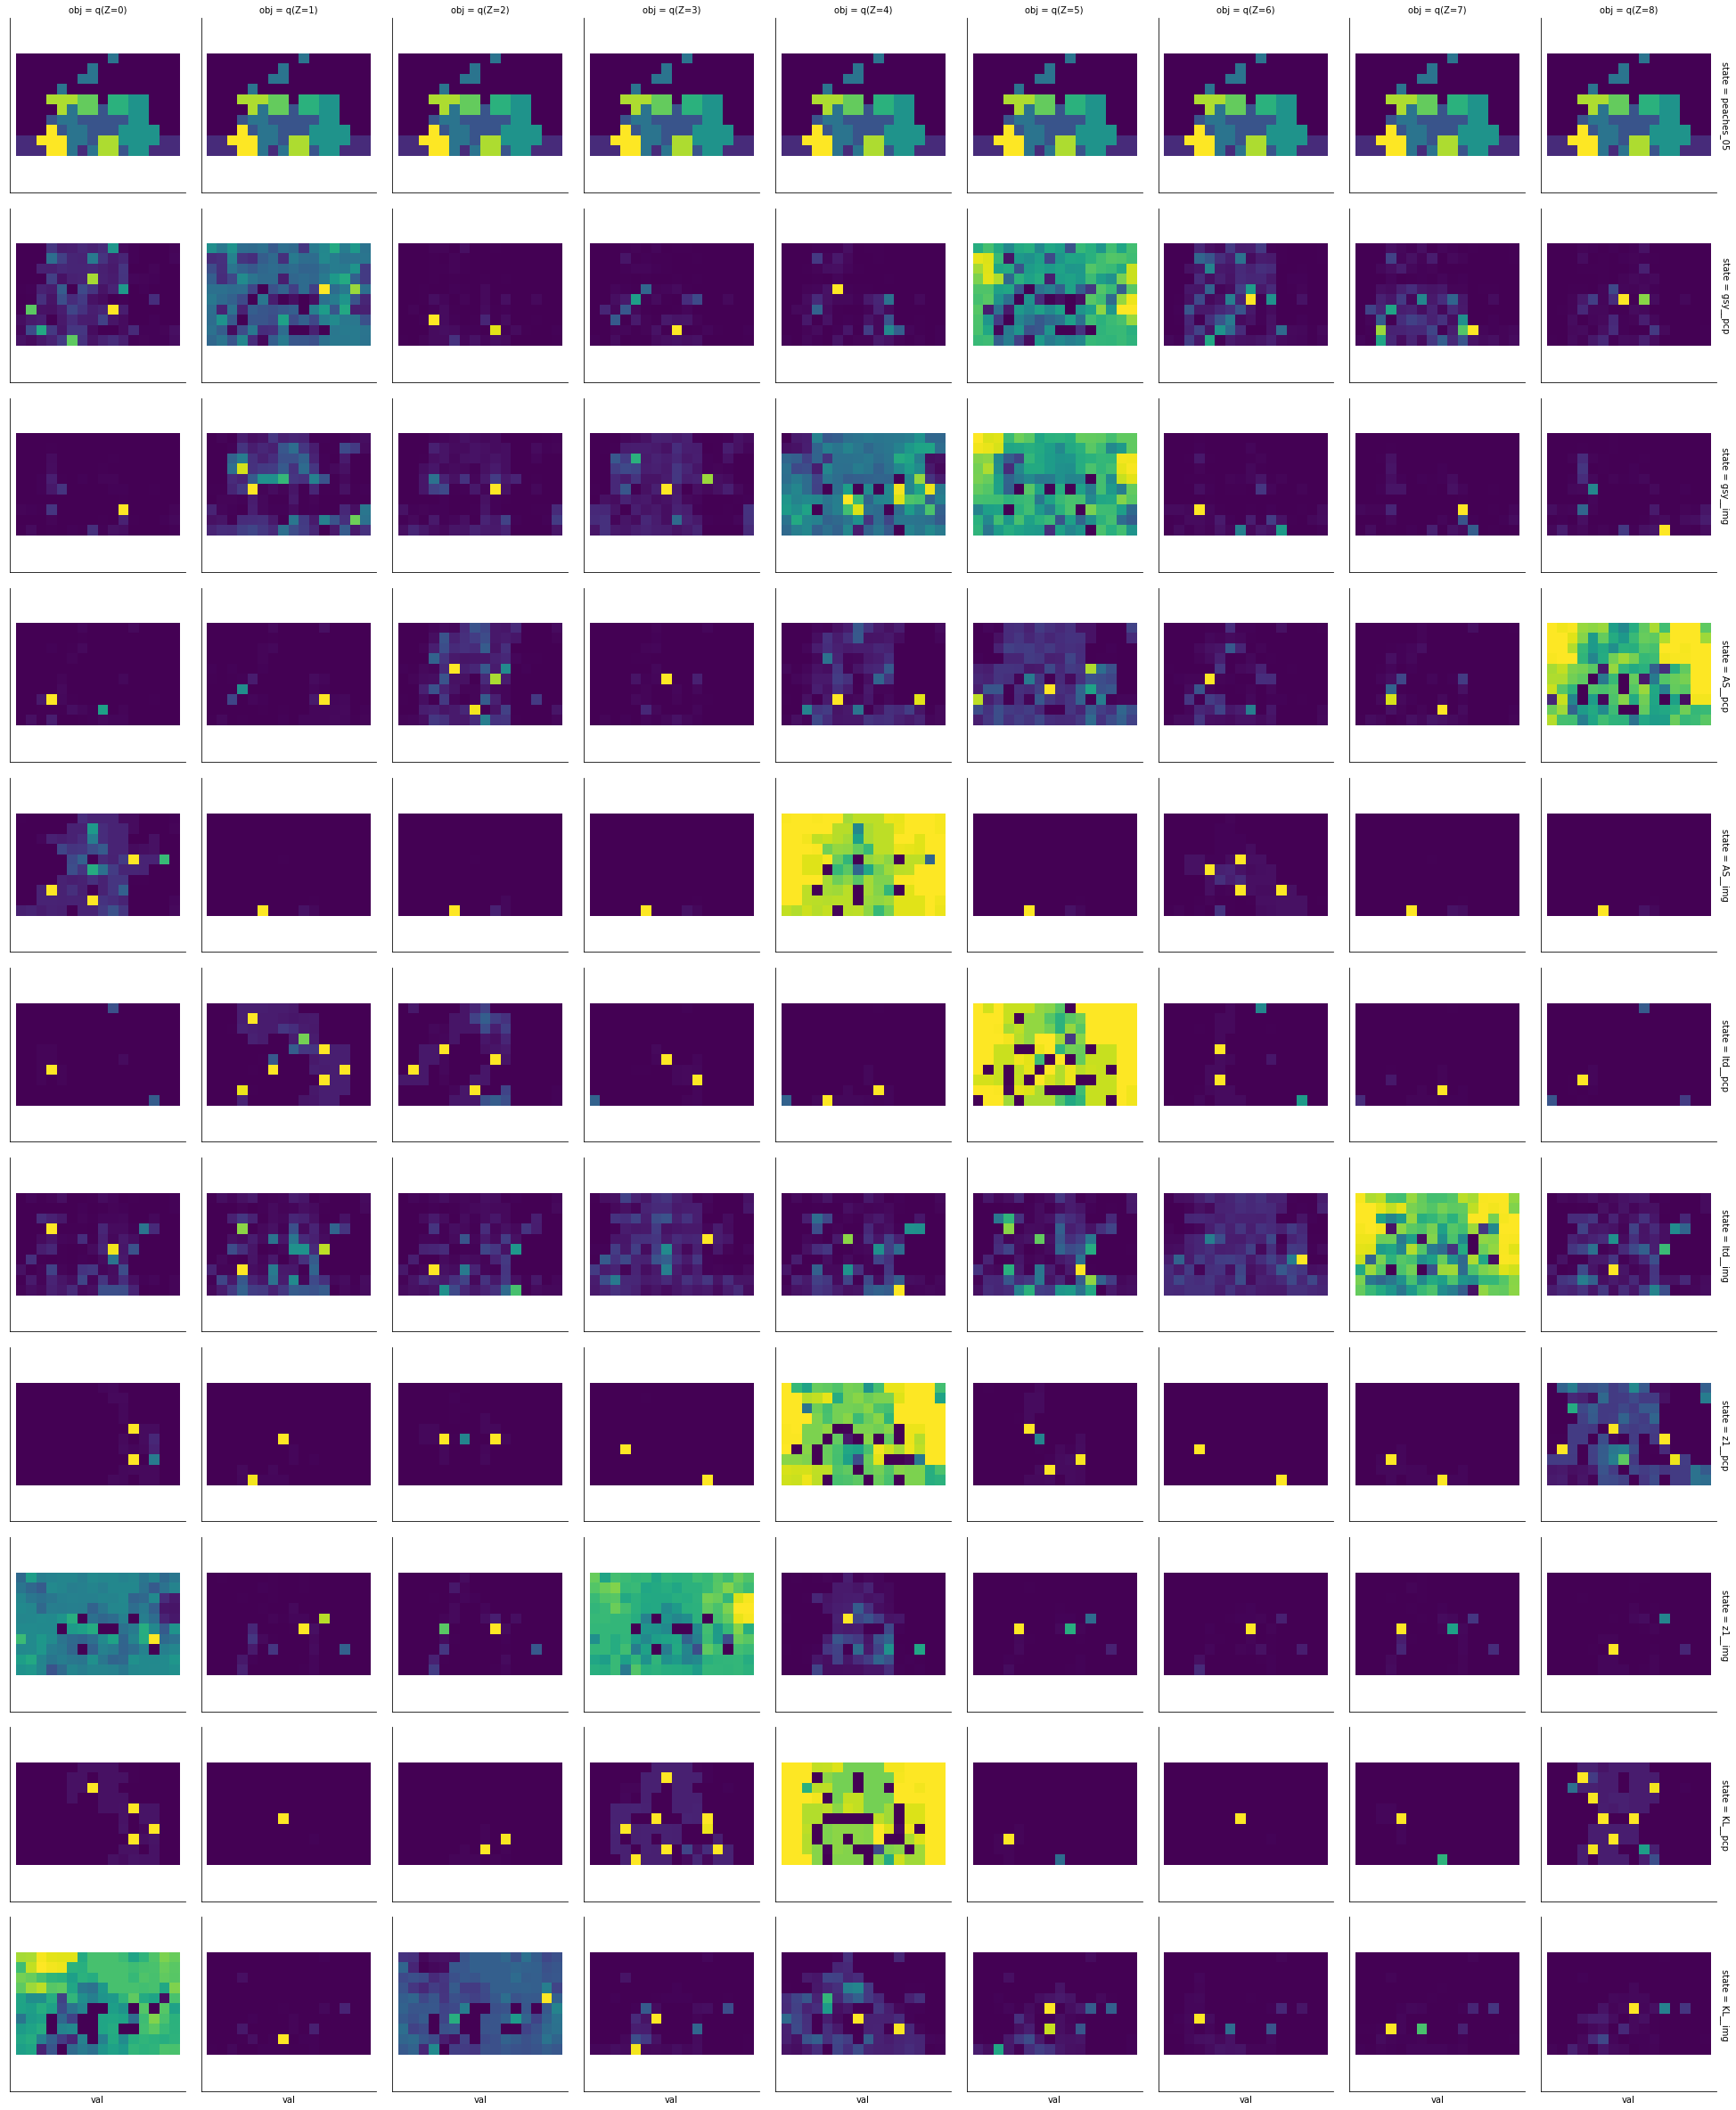

In [16]:
K = 9
grapeDf = group_display_qZ('peaches_05', models, (10,16), K)

## Model performance

### Prediction of responses
Harder to predict for imagery--but not always. For KL, gsy, z1 imagery peaches is better predicted. Weird

In [17]:
##pull each model, set current, predict performance to windows, store in a list, add to 
prc_correct = []
for _,dfRows in models.iterrows():
    bestModel = dfRows['model']
    bestModel.update_current(bestModel.testIdx)
    prc_correct += [percent_correct(bestModel)]

    
metricsDf = make_new_df('prediction', prc_correct, metricsDf)    
metricsDf

/usr/local/lib/python2.7/dist-packages/theano/tensor/subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


,subject,state,target,subject+target,forgetting,halucinating,prediction
0,gsy,pcp,candle_01,gsycandle_01,0.001000,0.001000,100.000000
1,gsy,pcp,peaches_05,gsypeaches_05,0.245408,0.001000,44.117647
2,gsy,img,candle_01,gsycandle_01,0.041735,0.021346,92.647059
3,gsy,img,peaches_05,gsypeaches_05,0.225041,0.021341,57.352941
4,AS,pcp,candle_01,AScandle_01,0.021367,0.001000,97.058824
5,AS,pcp,peaches_05,ASpeaches_05,0.143571,0.041687,57.352941
6,AS,img,candle_01,AScandle_01,0.062102,0.041691,75.000000
7,AS,img,peaches_05,ASpeaches_05,0.082469,0.021345,63.235294
8,ltd,pcp,candle_01,ltdcandle_01,0.001000,0.021347,91.176471
9,ltd,pcp,peaches_05,ltdpeaches_05,0.041735,0.021346,75.000000


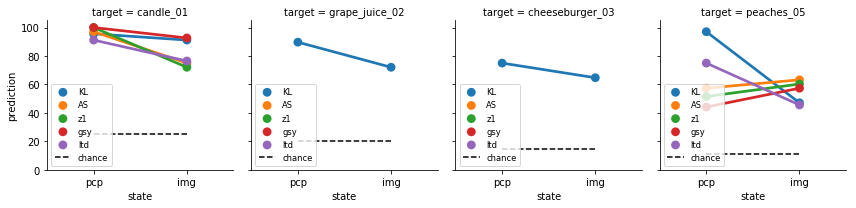

In [43]:
chance_levels = (100./np.array([4, 5, 7,9])).tolist()
pFG = sns.FacetGrid(metricsDf,col='target',ylim=(0,105),col_order=['candle_01', 'grape_juice_02', 'cheeseburger_03', 'peaches_05'])
pFG.map(sns.pointplot,'state','prediction','subject',hue_order=['KL','AS','z1', 'gsy', 'ltd'], palette = sns.color_palette())
for i,ax in enumerate(pFG.axes.flat):
    ax.hlines(chance_levels[i],0,1,linestyles='--', label='chance')
    ax.legend(loc='lower left',fontsize='small')

### Image identification

relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/candle_01_mask.png
after downsampling, number of object in candle_01 is 3
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/peaches_05_mask.png
after downsampling, number of object in peaches_05 is 9
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/candle_01_mask.png
after downsampling, number of object in candle_01 is 3
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/peaches_05_mask.png
after downsampling, number of object in 

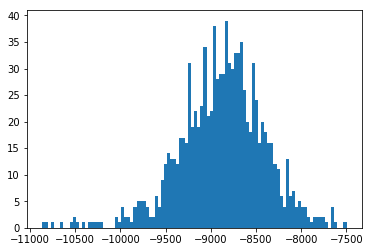

In [19]:
##pull each model, set current, predict performance to windows, store in a list, add to
id_correct = []
for _,dfRows in models.iterrows():
    
    ##get model and create an analyzer
    bestModel = dfRows['model']
    comem=comembership_analyzer(bestModel)
    
    ##grab and process the target image
    target = dfRows['target']
    targetObjectMap = load_target_image(target,(comem.D1,comem.D2)).astype(intX)
    targetObjectMap = np.digitize(targetObjectMap,np.unique(targetObjectMap))-1
    K = len(np.unique(targetObjectMap))
    print 'after downsampling, number of object in %s is %d' %(target, K)
    targetObjectMap = to_one_hot_func(targetObjectMap.flatten().astype(intX),K)
    targIdx = 1000
    
    ##make lure images
    lureZ = make_object_map_stack(K, np.ceil(np.sqrt(K)*np.sqrt(2)), np.ceil(np.sqrt(K)*np.sqrt(2)), (comem.D1,comem.D2),targIdx+1)
    lureZ[targIdx] = targetObjectMap.T
    logProbs, bestZ = comem.posterior_image_identification(lureZ)
    rank = np.where(np.argsort(logProbs)==targIdx)[0][0]
    id_correct += [rank]
    if rank == 1000:
        saveLogProbs=logProbs
        saveBestZ = bestZ

##check sanity
print 'these two number should be the same:'
print logProbs[targIdx]
print logProbs[np.argsort(logProbs)[rank]]
print '\n'
print 'these should too'
_=plt.hist(saveLogProbs,bins=100)
print saveLogProbs[saveBestZ]
print saveLogProbs[targIdx]


In [20]:
metricsDf = make_new_df('image_id', id_correct, metricsDf)    
metricsDf

,subject,state,target,subject+target,forgetting,halucinating,prediction,image_id
0,gsy,pcp,candle_01,gsycandle_01,0.001000,0.001000,100.000000,1000
1,gsy,pcp,peaches_05,gsypeaches_05,0.245408,0.001000,44.117647,829
2,gsy,img,candle_01,gsycandle_01,0.041735,0.021346,92.647059,1000
3,gsy,img,peaches_05,gsypeaches_05,0.225041,0.021341,57.352941,997
4,AS,pcp,candle_01,AScandle_01,0.021367,0.001000,97.058824,1000
5,AS,pcp,peaches_05,ASpeaches_05,0.143571,0.041687,57.352941,1000
6,AS,img,candle_01,AScandle_01,0.062102,0.041691,75.000000,1000
7,AS,img,peaches_05,ASpeaches_05,0.082469,0.021345,63.235294,1000
8,ltd,pcp,candle_01,ltdcandle_01,0.001000,0.021347,91.176471,1000
9,ltd,pcp,peaches_05,ltdpeaches_05,0.041735,0.021346,75.000000,1000


##### Note the "below chance"  performance for "grape juice" and "peaches".
Worse than chance implies a distorted mental image.

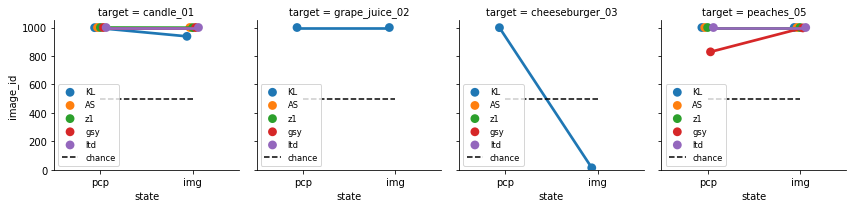

In [44]:
chance_levels = [500]*4
pFG = sns.FacetGrid(metricsDf,col='target',ylim=(0,1050),col_order=['candle_01', 'grape_juice_02', 'cheeseburger_03', 'peaches_05'])
pFG.map(sns.pointplot,'state','image_id','subject',hue_order=['KL','AS','z1', 'gsy', 'ltd'],dodge=True, palette = sns.color_palette())
for i,ax in enumerate(pFG.axes.flat):
    ax.hlines(chance_levels[i],0,1,linestyles='--', label='chance')
    ax.legend(loc='lower left',fontsize='small')

## Entropy

In [22]:
##for each subject+target, calculate
#-entropy for each state H(pcp), H(img)
#-KL(pcp|img)KL(img|pcp)
#crossentropy, HX(pcp,img) = KL(pcp|img)+H(pcp), and vice versa 

In [23]:
entropy = []
kl = []
crossentropy = []
subject = []
target = []
state = []
for name,grp in models.groupby(['subject', 'target']):
    pcpComem = comembership_analyzer(grp[grp['state']=='pcp'].model.values[0])
    imgComem = comembership_analyzer(grp[grp['state']=='img'].model.values[0])
    Hpcp = pcpComem.entropy()
    Himg = imgComem.entropy()
    KLpcp_img = pcpComem.kl_divergence(imgComem.qZ)
    KLimg_pcp = imgComem.kl_divergence(pcpComem.qZ)
    HXpcp_img = KLpcp_img + Hpcp
    HXimg_pcp = KLimg_pcp + Himg
    entropy += [Hpcp,Himg]
    kl += [KLpcp_img, KLimg_pcp]
    crossentropy += [HXpcp_img, HXimg_pcp]
    state += ['pcp', 'img']
    subject += [name[0]]*2
    target += [name[1]]*2

    



relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation f

In [24]:
entropyDf = pd.DataFrame({'H':entropy, 'HX':crossentropy, 'KL':kl, 'subject':subject,'target':target,'state':state})
entropyDf

,H,HX,KL,state,subject,target
0,944.679768,13421.633754,12476.953986,pcp,AS,candle_01
1,3970.863809,46728.982292,42758.118483,img,AS,candle_01
2,6756.178165,14441.804506,7685.626341,pcp,AS,peaches_05
3,4487.970616,10822.338747,6334.368131,img,AS,peaches_05
4,8689.030040,56722.098391,48033.068351,pcp,KL,candle_01
5,2432.922587,8949.428748,6516.506160,img,KL,candle_01
6,5395.554764,10609.976817,5214.422053,pcp,KL,cheeseburger_03
7,7798.309855,27085.936066,19287.626212,img,KL,cheeseburger_03
8,3510.392538,23179.102860,19668.710322,pcp,KL,grape_juice_02
9,2812.090780,29502.363477,26690.272697,img,KL,grape_juice_02


In [25]:
entropyDf = pd.merge(metricsDf, entropyDf,on=['state','subject','target'])

In [26]:
entropyDf

,subject,state,target,subject+target,forgetting,halucinating,prediction,image_id,H,HX,KL
0,gsy,pcp,candle_01,gsycandle_01,0.001000,0.001000,100.000000,1000,2490.267147,27061.702036,24571.434889
1,gsy,pcp,peaches_05,gsypeaches_05,0.245408,0.001000,44.117647,829,6807.756617,8640.938897,1833.182280
2,gsy,img,candle_01,gsycandle_01,0.041735,0.021346,92.647059,1000,1084.082542,16487.208206,15403.125664
3,gsy,img,peaches_05,gsypeaches_05,0.225041,0.021341,57.352941,997,7613.890649,10220.298530,2606.407882
4,AS,pcp,candle_01,AScandle_01,0.021367,0.001000,97.058824,1000,944.679768,13421.633754,12476.953986
5,AS,pcp,peaches_05,ASpeaches_05,0.143571,0.041687,57.352941,1000,6756.178165,14441.804506,7685.626341
6,AS,img,candle_01,AScandle_01,0.062102,0.041691,75.000000,1000,3970.863809,46728.982292,42758.118483
7,AS,img,peaches_05,ASpeaches_05,0.082469,0.021345,63.235294,1000,4487.970616,10822.338747,6334.368131
8,ltd,pcp,candle_01,ltdcandle_01,0.001000,0.021347,91.176471,1000,2127.214532,7426.307501,5299.092969
9,ltd,pcp,peaches_05,ltdpeaches_05,0.041735,0.021346,75.000000,1000,3520.892757,9302.032772,5781.140014


##### Imagery = more entropy
- KLCandle bizzarre here too.
- huge spread of entropies for both perception and imagery, but generally the assertion above holds


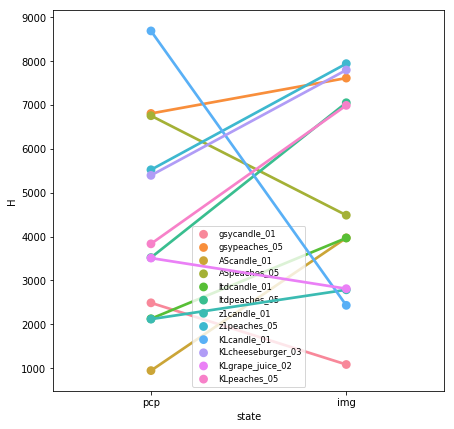

In [27]:
fig = plt.figure(figsize=(7,7))
sns.pointplot('state', 'H', 'subject+target',entropyDf)
plt.legend(loc='best',fontsize='small')

##### As $H(q_{pcp})$ increases, $D_{KL}(q_{pcp} || q_{vis})$ increases
Which is just the opposite of the result in analysis_003. So this is all shitty and noisy and need multiple resamplings to get right

In [28]:

pcpDf = entropyDf[entropyDf['state']=='pcp']
imgDf = entropyDf[entropyDf['state']=='img']
wideDf = pd.merge(pcpDf,imgDf,on=['subject', 'target'], suffixes=('_pcp','_img'))
wideDf = wideDf.drop(columns=['subject+target_pcp', 'state_pcp', 'state_img'])
wideDf = wideDf.rename(columns={'subject+target_img':'subject+target'})
wideDf    

,subject,target,forgetting_pcp,halucinating_pcp,prediction_pcp,image_id_pcp,H_pcp,HX_pcp,KL_pcp,subject+target,forgetting_img,halucinating_img,prediction_img,image_id_img,H_img,HX_img,KL_img
0,gsy,candle_01,0.001000,0.001000,100.000000,1000,2490.267147,27061.702036,24571.434889,gsycandle_01,0.041735,0.021346,92.647059,1000,1084.082542,16487.208206,15403.125664
1,gsy,peaches_05,0.245408,0.001000,44.117647,829,6807.756617,8640.938897,1833.182280,gsypeaches_05,0.225041,0.021341,57.352941,997,7613.890649,10220.298530,2606.407882
2,AS,candle_01,0.021367,0.001000,97.058824,1000,944.679768,13421.633754,12476.953986,AScandle_01,0.062102,0.041691,75.000000,1000,3970.863809,46728.982292,42758.118483
3,AS,peaches_05,0.143571,0.041687,57.352941,1000,6756.178165,14441.804506,7685.626341,ASpeaches_05,0.082469,0.021345,63.235294,1000,4487.970616,10822.338747,6334.368131
4,ltd,candle_01,0.001000,0.021347,91.176471,1000,2127.214532,7426.307501,5299.092969,ltdcandle_01,0.062102,0.021346,76.470588,1000,3968.180638,22257.016788,18288.836150
5,ltd,peaches_05,0.041735,0.021346,75.000000,1000,3520.892757,9302.032772,5781.140014,ltdpeaches_05,0.265776,0.041679,45.588235,1000,7051.424673,28883.192961,21831.768287
6,z1,candle_01,0.021367,0.001000,100.000000,1000,2118.424956,19884.026402,17765.601447,z1candle_01,0.041735,0.062038,72.058824,999,2787.291982,36499.449110,33712.157128
7,z1,peaches_05,0.062102,0.021346,51.470588,1000,5523.572928,10463.100787,4939.527859,z1peaches_05,0.163939,0.021343,60.294118,1000,7942.787395,21944.040540,14001.253145
8,KL,candle_01,0.408347,0.001000,95.588235,999,8689.030040,56722.098391,48033.068351,KLcandle_01,0.041735,0.001000,91.176471,938,2432.922587,8949.428748,6516.506160
9,KL,cheeseburger_03,0.021367,0.001000,75.000000,999,5395.554764,10609.976817,5214.422053,KLcheeseburger_03,0.306510,0.021338,64.705882,14,7798.309855,27085.936066,19287.626212


/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


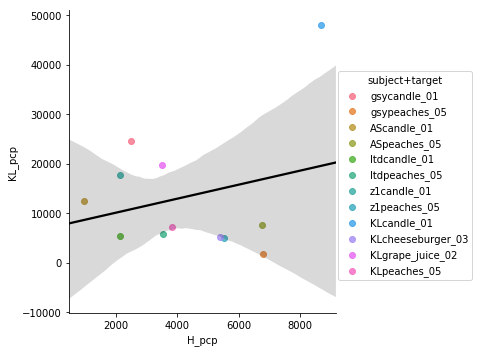

In [29]:
foo = sns.lmplot('H_pcp', 'KL_pcp',wideDf,hue='subject+target',fit_reg=False)
sns.regplot('H_pcp', 'KL_pcp',wideDf,scatter=False,color='k')


##### If entropy gets too high, what happens to identifiability?

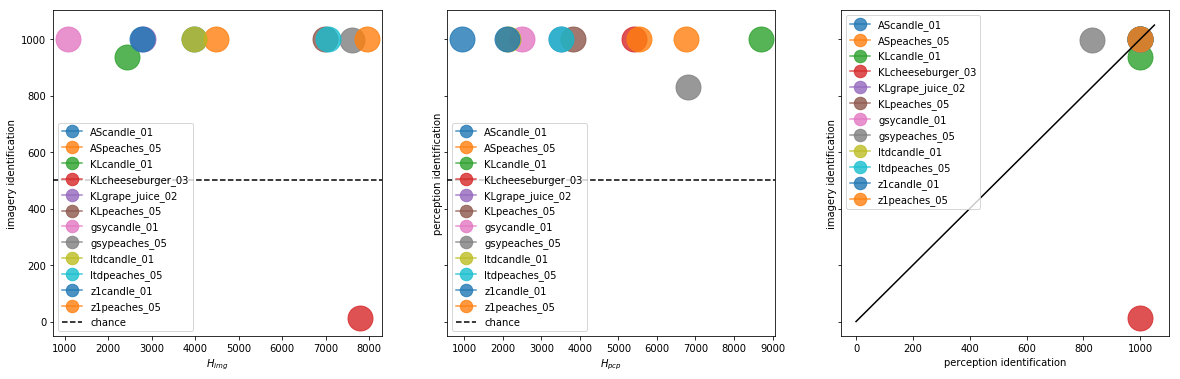

In [30]:
fig = plt.figure(figsize=(20,6))
ax = fig.subplots(nrows=1,ncols=3, sharey=True)
sharedYLim=1050
for name,grp in wideDf.groupby('subject+target'):
    H_img = grp.H_img.values
    img_id_img = grp.image_id_img.values
    ax[0].plot(H_img,img_id_img, 'o-', label=name,markersize=25,alpha=0.8)
    H_pcp = grp.H_pcp.values
    img_id_pcp = grp.image_id_pcp.values
    ax[1].plot(H_pcp,img_id_pcp, 'o-', label=name,markersize=25,alpha=0.8)
    ax[2].plot(img_id_pcp,img_id_img, 'o-', label=name,markersize=25,alpha=0.8)
#     ax[3].plot(H_pcp,H_img, 'o-', label=name,markersize=25,alpha=0.8)
    

chance = 500
ax[0].axhline(y=500, label='chance', linestyle='--',color='k')
ax[0].set_ylabel('imagery identification')
ax[0].set_xlabel('$H_{img}$')
ax[0].legend(markerscale=.5,loc = 'best',)

chance = 500
ax[1].axhline(y=500, label='chance', linestyle='--', color='k')
ax[1].set_ylabel('perception identification')
ax[1].set_xlabel('$H_{pcp}$')
ax[1].legend(markerscale=.5,loc = 'best',)


ax[2].plot(np.linspace(0.,sharedYLim),np.linspace(0.,sharedYLim),'k',)
ax[2].set_xlabel('perception identification')
ax[2].set_ylabel('imagery identification')
ax[2].legend(markerscale=.5,loc = 'best',)

# ax[3].plot(np.linspace(0.,sharedYLim*8),np.linspace(0.,sharedYLim*8),'k',)
# ax[3].set_xlabel('$H_{pcp}$')
# ax[3].set_ylabel('$H_{img}$')
# ax[3].legend(markerscale=.5,loc = 'best',)
# ax[3].set_aspect('equal')

# sns.pointplot('state', 'halucinating', data=metricsDf,hue='subject+target',ax=ax[1],aspect=1,scale=2.5)
# ax[1].set_ylim(None,sharedYLim)
# sns.pointplot('state', 'forgetting', data=metricsDf,hue='subject+target',ax=ax[2],aspect=1,scale=2.5)
# ax[2].set_ylim(None,sharedYLim)

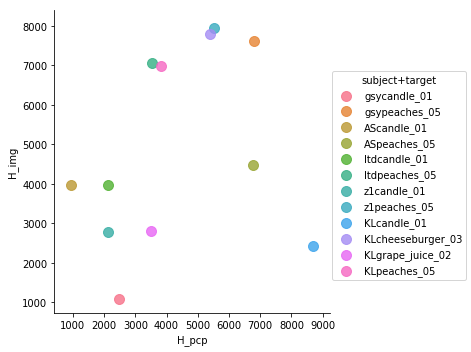

In [31]:
ax = sns.lmplot('H_pcp','H_img', wideDf,hue='subject+target', fit_reg=False,  scatter_kws={'s':100})

## Distortion

In [32]:
##grab model for one target
#grab the target, make masks of objects, plot each object in a separate frame
##groubpy subject
##for each subject get pcp/img, for each make comem instance
##for each object run size analysis for both pcp/img
##plot the masked object
##underneath, plot tuning functions in same plot with different colors

In [33]:
def split_and_downsample_object_map(target_image_name, shape, show=False):
    targetObjectMap = load_target_image(target_image_name,shape=None).astype(intX)
    targetObjectMap = np.digitize(targetObjectMap,np.unique(targetObjectMap))-1
    nativeShape = targetObjectMap.shape
    K = len(np.unique(targetObjectMap))
    targetObjectMap1Hot = to_one_hot_func(targetObjectMap.flatten().astype(intX), K).T
    print targetObjectMap1Hot.shape
    masks = np.zeros((K,shape[0],shape[1]))
    for k in range(K):
        mask = targetObjectMap1Hot[k].reshape(nativeShape)
        mask = resize(mask,shape,order=0,preserve_range=True).astype(intX)
        masks[k,:,:] = mask
    
    if show:
        fig = plt.figure(figsize=(20,10))
        for k in range(K):
            plt.subplot(1,K,k+1)
            plt.imshow(masks[k])
    return masks
        


opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/grape_juice_02_mask.png
(5, 222000)


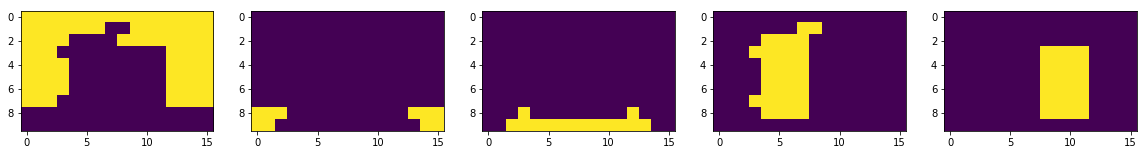

In [34]:
_=split_and_downsample_object_map('grape_juice_02', (10,16),show=True)

In [35]:
def group_display_size_tuning(target_image, modelDf, image_shape,figsize=(10,10)):
    masks = split_and_downsample_object_map(target_image, image_shape, show=False)
    targDf = modelDf[modelDf['target']==target_image]
    S = len(targDf['subject'].unique())
    K = masks.shape[0]
    ##set up the plot
    fig = plt.figure(1,figsize=figsize)
    grid = lambda x: plt.subplot(S+1,K,x+1)

    for k in range(K):       
        grid(k).imshow(masks[k])
        grid(k).set_xticks([])
        grid(k).set_yticks([])
        grid(k).set_title('%s|%2d' %(target_image,k))
#         plt.axis('tight')
    s =1
    for name,grp in targDf.groupby(['subject']):
        print name
        pcpComem = comembership_analyzer(grp[grp['state']=='pcp'].model.values[0])
        imgComem = comembership_analyzer(grp[grp['state']=='img'].model.values[0])
        for k in range(pcpComem.K):
            knownPixels = masks[k].flatten().astype('bool')
            knownSize = np.sum(knownPixels)
            if not np.any(knownPixels):
                pcpLogProbs = 0
                imgLogProbs = 0
                sizes=0
            else:
                pcpLogProbs,_= pcpComem.optimize_object_scale(knownPixels)
                imgLogProbs,scaledMasks= imgComem.optimize_object_scale(knownPixels)
                sizes = map(lambda x: np.sum(np.sum(x)), scaledMasks)
            grid(s*K+k).plot(sizes, pcpLogProbs, '#008080')
            grid(s*K+k).set_yticks([])
            imgAx = grid(s*K+k).twinx()
            imgAx.plot(sizes, imgLogProbs, '#FF7F50')
            imgAx.set_yticks([])
            imgAx.axvline(knownSize, linestyle='--',color='k')
        imgAx.set_ylabel('subject %s \n (log.prob)' %(name))
        s+=1

### Size distortion
My take on this is now changing. Now it's looking more like each model is pretty insensitive to the details of the geometry of objects, but for the most part just prefers objects of certain small size (like maybe 1 pixel) at any location, or one big object that covers the whole image. 

I note that for "peaches" the preference for small over big objects is much stronger.

Should also probably consider "every pixel is it's own object" as a baseline.

##### The candle

opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/candle_01_mask.png
(4, 222000)
AS
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/tnaselar/repo.musc/Docs/tnaselar/code/Python/imagery_psychophysics/src/variational.py:1388: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  objectMaps[[img,row,col]] = 1
/home/tnaselar/repo.musc/Docs/tnaselar/code/Python/imagery_psychophysics/src/variational.py:1400: FutureWarning: Using a non-tuple sequence

KL
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
gsy
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
ltd
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
z1
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15


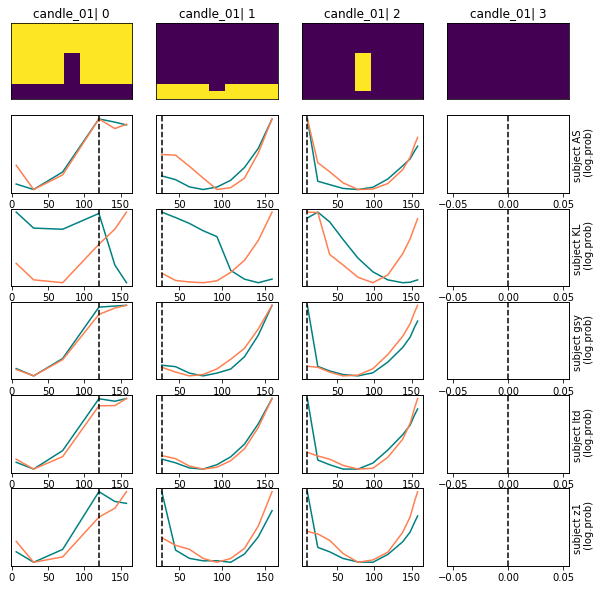

In [36]:
group_display_size_tuning('candle_01', models, (10,16))

opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/grape_juice_02_mask.png
(5, 222000)
KL
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15


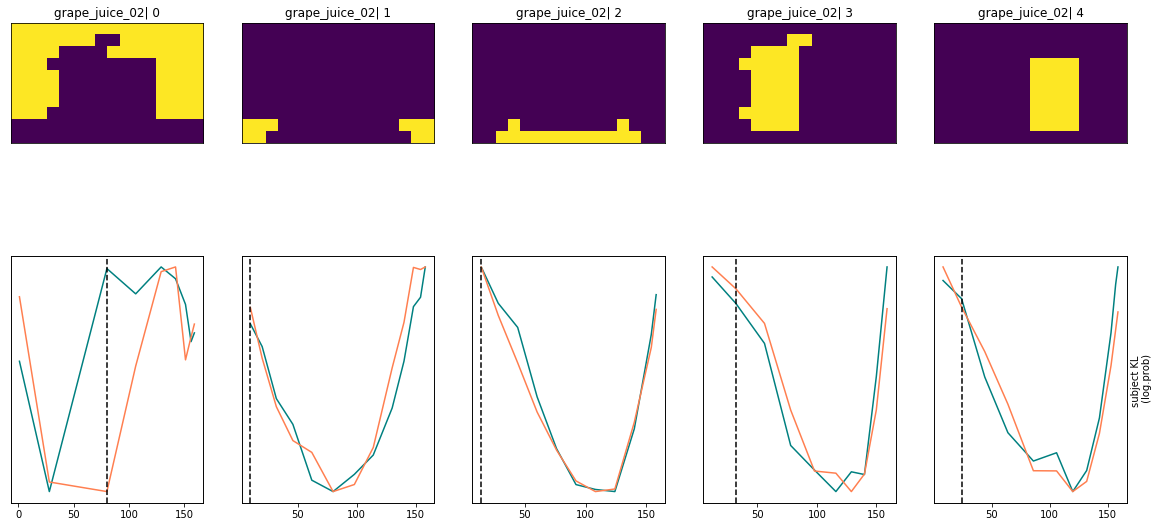

In [37]:
group_display_size_tuning('grape_juice_02', models, (10,16),figsize=(20,10))

opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/cheeseburger_03_mask.png
(7, 222000)
KL
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15


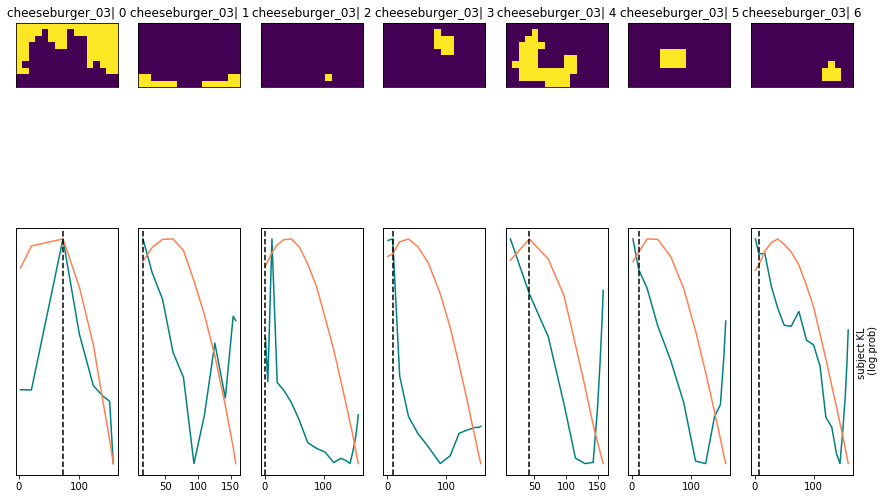

In [38]:
group_display_size_tuning('cheeseburger_03', models, (10,16),figsize=(15,10))

opening /home/tnaselar/FAST/imagery_psychophysics/multi_poly_probes/masks/processed/peaches_05_mask.png
(9, 222000)
AS
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
KL
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
gsy
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
ltd
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e-15
relaxation fudge factor: 1.000000e-13
relaxation fudge factor: 1.000000e-14
relaxation fudge factor: 1.000000e

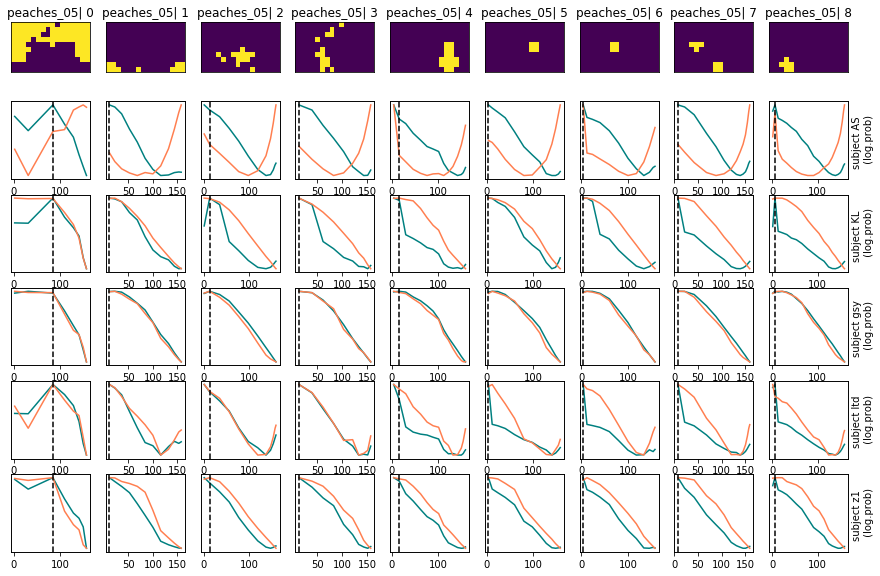

In [39]:
group_display_size_tuning('peaches_05', models, (10,16),figsize=(15,10))